# Explicabilidad de modelos de Machine Learning

Muchos modelos modernos de Machine Learning (Random Forest, Gradient Boosting, Redes Neuronales Artificiales, SVM con kernel) pueden alcanzar niveles de precisión altos, pero son difíciles de interpretar. Este hecho plantea problemas para aplicaciones en campos como la medicina, las finanzas, la seguridad y otros sistemas críticos, incluso, existen **normativas internacionales** que exigen a los diseñadores de aplicaciones que basadas en IA/ML poder responder a preguntas como:

- ¿Por qué el modelo tomó esta decisión?

- ¿Qué variables fueron más importantes?

- ¿Qué pasaría si cambiamos una característica?

## Tipos de explicabilidad

**Según el alcance**

- Global: comportamiento general del modelo (similar a las técnicas que estiman la importancia de variables)

- Local: explicación de una predicción concreta

**Según el modelo**

- Model-specific: dependen del modelo (árboles, redes)

- Model-agnostic: aplicables a cualquier modelo

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Cargar datos
X, y = load_breast_cancer(return_X_y=True, as_frame=True)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# Modelo
model = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)

model.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

## SHAP Values

SHAP (SHapley Additive exPlanations) [1] se basa en la teoría de juegos cooperativos. Cada variable es vista como un jugador que contribuye a la predicción final, la cual se descompone como:

$$f({\bf{x}}) = \phi_0 + \sum_{i=1}^{d} \phi_i({\bf{x}})$$

donde

- $\phi_0 = \mathbb{E}[f(X)]$ es el baseline (predicción media del modelo)
- $\phi_i({\bf{x}})$ es la contribución local de la característica $i$

La contribución $\phi_i({\bf{x}})$ se estima como:

$$\phi_i({\bf{x}}) = \sum_{S \subseteq N \setminus \{i\}} \frac{|S|! \, (d - |S| - 1)!}{d!} \left[ f_{S \cup \{i\}}({\bf{x}}) - f_S({\bf{x}}) \right]$$

donde

- $N = \{1, \dots, d\}$ el conjunto de características

- $S \subseteq N \setminus \{i\}$ un subconjunto de características

- $f_S(x)$ el modelo evaluado usando solo las características en $S$.


In [3]:
import shap

In [4]:
y_est = model.predict(X_test)

# Inicializar explicador
explainer = shap.TreeExplainer(model)

# Calcular SHAP values
shap_values = explainer(X_test)

### Explicación global

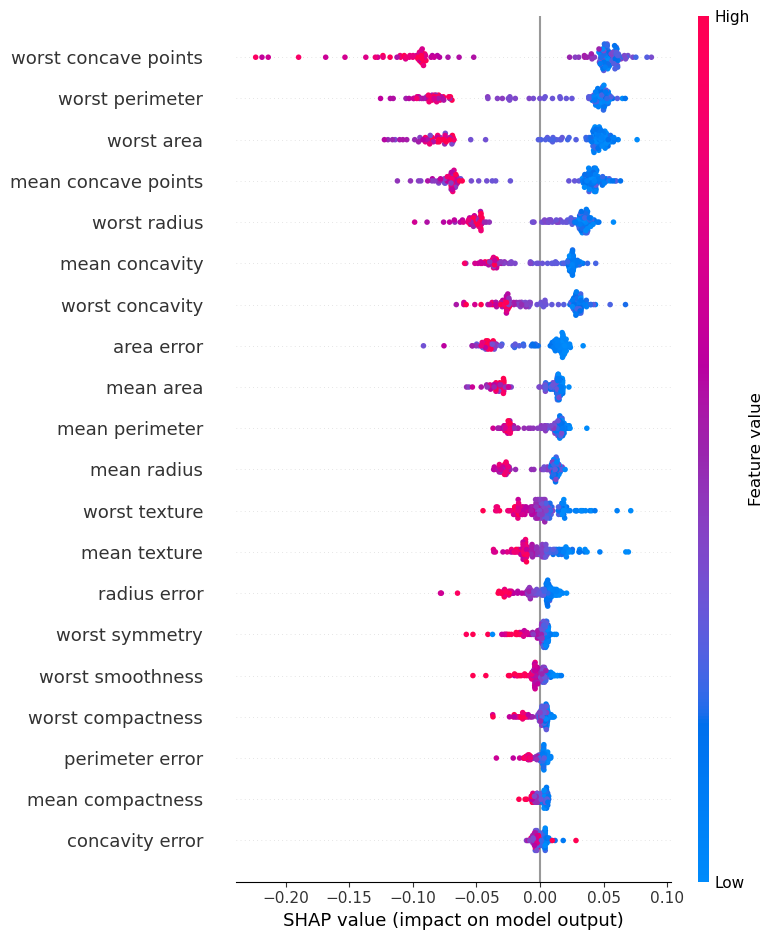

In [5]:
shap.summary_plot(
    shap_values[:,:,1],
    X_test
)

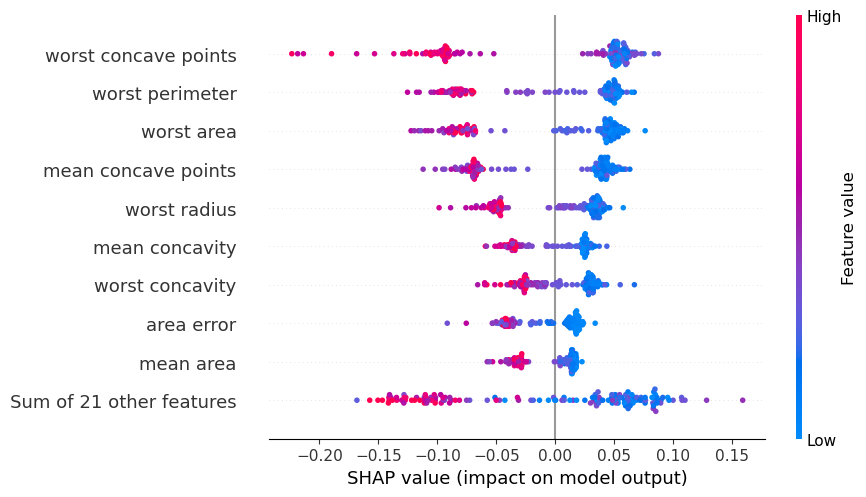

In [6]:
shap.plots.beeswarm(shap_values[:,:,1])

### Explicación local: una observación

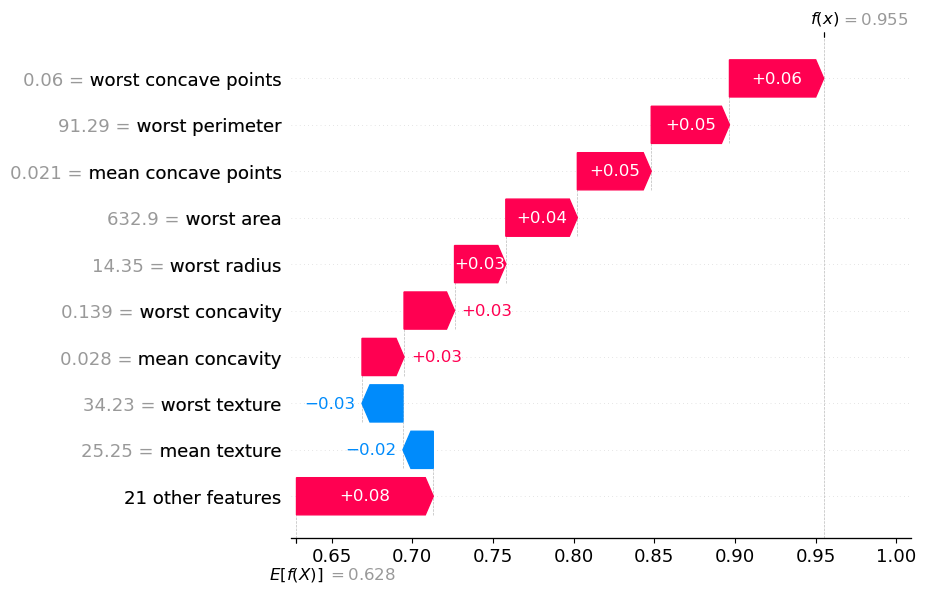

In [7]:
i = 10
shap.plots.waterfall(shap_values[i,:,y_est[i]])

In [8]:
shap.force_plot(explainer.expected_value[1], shap_values.values[i,:,1],X.iloc[i,:], plot_cmap="DrDb")

## LIME

LIME (Local Interpretable Model-agnostic Explanations) [2] explica una predicción local aproximando el modelo complejo por un modelo simple local. El procedimiento que sigue LIMe es el siguiente:

- Dada una muestra $\bf{x}$, genera un conjunto de datos "falso", aplicando ligeras perturbaciones aleatorias a las características de la muestra.
- Estima un peso para cada una de las muestras falsas con base en la distancia a la muestra original.
- Para cada una de las muestras generadas, obtiene las predicciones del modelo entrenado previamente.
- Entrena un modelo sustituto simple, por ejemplo, una regresión lineal, y los pesos asignados por el modelo durante el entrenamiento son usados como medidas que explican la importancia de las variables en la predicción.

In [9]:
from lime.lime_tabular import LimeTabularExplainer

In [10]:
explainer_lime = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns,
    class_names=["maligno", "benigno"],
    mode="classification"
)

In [13]:
exp = explainer_lime.explain_instance(
    X_test.iloc[i].values,
    model.predict_proba,
    num_features=8
)

exp.show_in_notebook()

/Users/julian/opt/anaconda3/envs/ml_base/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
